<html>
<body>
    <center> 
        <h1><u>Assignment 2</u></h1>
        <h3> Customizing the code to run your own experiments</h3>
    </center>
</body>
</html>

### Learning Outcomes

In assignment 1 we covered two things mainly - (1) introducing you to a pipeline for coding ML projects - the data loader, loading models, calculating losses and using an optimizer to update the weights of the model (i.e. learning  the weights of the model). But we didn't look into the nuts and bolts of these pieces. Assignment 2 will delve deeper into these pieces and learn how to customize them.

There are two major components:

- Learning how to load your own data.
- Writing a custom CNN model to classify these images. 

### Please specify your Name, Email ID and forked repository url here:
- Name: Leannah Newman
- Email: leannahnewman@hms.harvard.edu
- Link to your forked github repository: https://github.com/leannahnewman/Harvard_BAI

In [1]:
### General libraries useful for python ###

import os
import sys
from tqdm.notebook import tqdm
import json
import random
import pickle
import copy
from IPython.display import display
import ipywidgets as widgets

In [2]:
## from google.colab import drive
## drive.mount('/content/drive', force_remount=True)

In [3]:
### Finding where you clone your repo, so that code upstream paths can be specified programmatically ####
work_dir = os.getcwd()
print(work_dir)
git_dir = '\\'.join(work_dir.split('\\')[:-1])
print('Your github directory is :%s'%git_dir)

C:\Users\leann\Documents\BAI\Harvard_BAI\assignment_2
Your github directory is :C:\Users\leann\Documents\BAI\Harvard_BAI


In [4]:
assignment_2_folder = work_dir
print(assignment_2_folder)

C:\Users\leann\Documents\BAI\Harvard_BAI\assignment_2


In [5]:
os.chdir(assignment_2_folder)

In [6]:
### Libraries for visualizing our results and data ###
from PIL import Image
import matplotlib.pyplot as plt

In [7]:
### Import PyTorch and its components ###
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

#### Let's load our flexible code-base which you will build on for your research projects in future assignments.

Like assignment 1, we are loading in our code-base for convenient dataloading/model loading etc.

In [8]:
### Making helper code under the folder res available. This includes loaders, models, etc. ###
sys.path.append('%s\\res\\'%git_dir)
from models.models import get_model
from loader.loader import get_loader

Models are being loaded from: C:\Users\leann\Documents\BAI\Harvard_BAI\res\models
Loaders are being loaded from: C:\Users\leann\Documents\BAI\Harvard_BAI\res\loader


In [9]:
### Setting up Weights and Biases for tracking your experiments. ###

## We have Weights and Biases (wandb.ai) integrated into the code for easy visualization of results and for tracking performance. `Please make an account at wandb.ai, and follow the steps to login to your account!`

## %pip install --upgrade git+git://github.com/wandb/client.git@task/debug-init-wandb#egg=wandb
## import wandb
## wandb.login()

#### See those paths printed above?

As earlier, models i.e. architectures are being loaded from `res/models`. In this assignment we will be using the ResNet18 architecture, which is being loaded from the script `res/ResNet.py`

### Specifying settings/hyperparameters for our code below ###

In [10]:
wandb_config = {}
wandb_config['batch_size'] = 10
wandb_config['base_lr'] = 0.01
wandb_config['model_arch'] = 'ResNet18'
wandb_config['num_classes'] = 10
wandb_config['run_name'] = 'assignment_2'

### If you are using a CPU, please set wandb_config['use_gpu'] = 0 below. However, if you are using a GPU, leave it unchanged ####
wandb_config['use_gpu'] = 1

wandb_config['num_epochs'] = 2
wandb_config['git_dir'] = git_dir

By changing above, different experiments can be run. For example, you can specify which model architecture to load, which dataset you will be loading, and so on.

### Data Loading ###

The most common task many of you will be doing in your projects will be running a script on a new dataset. In PyTorch this is done using data loaders, and it is extremely important to understand this works. In next assignment, you will be writing your own dataloader. For now, we only expose you to basic data loading which for the MNIST dataset for which PyTorch provides easy functions.

### Let's load our own custom dataset. We will be using the Cats vs Dogs dataset from Kaggle.com

Download the data from https://www.kaggle.com/c/dogs-vs-cats/data.

Store it in `assignment_2/data/` and unzip the files.

So, the train images should be inside the directory: Harvard_BAI/assignment_2/data/dogs-vs-cats/train/

Data Transforms tell PyTorch how to pre-process your data. Recall that images are stored with values between 0-255 usually. One very common pre-processing for images is to normalize to be 0 mean and 1 standard deviation. This pre-processing makes the task easier for neural networks. There are many, many kinds of normalization in deep learning, the most basic one being those imposed on the image data while loading it.

### Let's create a file list of all our image files

In [11]:
train_folder_files = os.listdir('%s\data\dogs-vs-cats\\train\\'%assignment_2_folder)
random.shuffle(train_folder_files)

In [12]:
total_points = len(train_folder_files)

In [13]:
train_files = train_folder_files[:int(0.8*total_points)]
val_files = train_folder_files[int(0.8*total_points):]

In [14]:
test_files = os.listdir('%s\data\dogs-vs-cats\\test1\\'%assignment_2_folder)

In [15]:
labels_dictionary = {}
with open('data\\train_file_list.txt','w') as F:
    for t in train_files:
        file_path = '%s\data\dogs-vs-cats\\train\%s'%(assignment_2_folder, t)
        if 'dog' in t:
            labels_dictionary[file_path] = 0
            print(file_path, file = F)
        elif 'cat' in t:
            labels_dictionary[file_path] = 1
            print(file_path, file = F)
        

with open('data\\val_file_list.txt','w') as F:
    for t in train_files:
        file_path = '%s\data\dogs-vs-cats\\train\%s'%(assignment_2_folder, t)
        if 'dog' in t:
            labels_dictionary[file_path] = 0
            print(file_path, file = F)
        elif 'cat' in t:
            labels_dictionary[file_path] = 1
            print(file_path, file = F)

with open('data\\test_file_list.txt','w') as F:
    for t in test_files:
        file_path = '%s\data\dogs-vs-cats\\test1\%s'%(assignment_2_folder, t)
        labels_dictionary[file_path] = -1
        print(file_path, file = F)

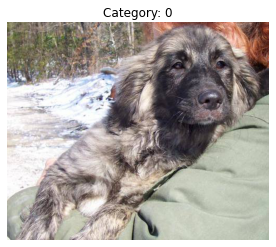

In [16]:
random_data_point = random.choice(list(labels_dictionary.keys()))
plt.imshow(Image.open(random_data_point))
plt.title('Category: %s'%labels_dictionary[random_data_point])
plt.axis('off')
plt.show()

Above, you should see 0 if it's a dog, 1 if it's a cat, and -1 if it's an image for which we don't have a label (test set).

In [17]:
with open('%s\data\\labels_dictionary.p'%assignment_2_folder, 'wb') as F:
    pickle.dump(labels_dictionary, F)

# Using our custom data-loader. 

Our data-loader is called cats_dogs_loader which is in `res/loader/cats_dogs_loader`. Read this file carefully! It's extremely important to understand this. 


An overview to help you understand the file: when you first call get_loader() below, you only tell python that you will be creating objects from the file cats_dogs_loader.

In [18]:
file_list_loader = get_loader('cats_dogs_loader')

In [19]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
     'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In assignment 1 we just used `torchvision.datasets.MNIST` to load MNIST data. But now we, can't rely on that function as we have a custom dataset. Here we learn how to handle such custom data.

We use our custom file_list_loader to load data that we have downloaded and unzipped. Above, we created file lists which contain paths to our train, validation and test datasets, here we will pass these file lists to the file_list_loader.

### Open the file cats_dogs_loaders.py, you will see a class FileListFolder.

In the file loader.py we load this class FileListFolder in the function get_loader. So, when we run get_loader("cats_dogs_loader") above, what is returned is the class FileListFolder. So, now when we run file_list_folder(), the arguments inside are passed to the class FileListFolder as described in cats_dogs_loader.py.

Thus, the first time you pass this, the __init__ function is run i.e. an object of that class is initialized. As you can see, the __init__ function in cats_dogs_loader.py requires 3 attributes - a file list, a labels dictionary and a pytorch transform object. To create a new data loader, we need to create a file lie cats_dogs_loder.py and make necessary changes to it.


The file lists contain paths to train/val/test files. The labels dictionary is a dictionary storing category numbers for each of these files, and the transforms are the pre-processing pytorch does to our loaded images before starting trainig.

In [20]:
dsets = {}
dsets['train'] = file_list_loader('%s\data\\train_file_list.txt'%assignment_2_folder, '%s\data\\labels_dictionary.p'%assignment_2_folder, data_transforms['train'])
dsets['val'] = file_list_loader('%s\data\\val_file_list.txt'%assignment_2_folder, '%s\data\\labels_dictionary.p'%assignment_2_folder, data_transforms['val'])
dsets['test'] = file_list_loader('%s\data\\test_file_list.txt'%assignment_2_folder, '%s\data\\labels_dictionary.p'%assignment_2_folder, data_transforms['test'])

In [21]:
### Above, we created datasets. Now, we will pass them into pytorch's inbuild dataloaders, 
### these will help us load batches of data for training.
dset_loaders = {}
dset_loaders['train'] = torch.utils.data.DataLoader(dsets['train'], batch_size=wandb_config['batch_size'], shuffle = True, num_workers=2,drop_last=False)
dset_loaders['val'] = torch.utils.data.DataLoader(dsets['val'], batch_size=wandb_config['batch_size'], shuffle = False, num_workers=2,drop_last=False)
dset_loaders['test'] = torch.utils.data.DataLoader(dsets['test'], batch_size=wandb_config['batch_size'], shuffle = True, num_workers=2,drop_last=False)

In [22]:
data_sizes = {}
data_sizes['train'] = len(dsets['train'])
data_sizes['val'] = len(dsets['val'])
data_sizes['test'] = len(dsets['test'])

## Loading model using PyTorch's in-built methods

In [23]:
model = torchvision.models.resnet18(pretrained = False)

Pytorch makes it easy to load many standard models like resnet18 above. There are many more available. You can see the list here -  https://github.com/pytorch/vision/tree/master/torchvision/models.

But, what if you want to build your own custom model? Below, we see how to load your custom models which you would write, and store in the `res/models/` folder. For current purposes, I have created a copy of the popular ResNet architectures in the folder which we will be loading and using.

### We will use the `get_model` functionality to load a CNN architecture.

In [24]:
### Since we pass ResNet18 below, this will get relayed to 
### the get_model function loaded from models.py. 
### As you can see, that would load the resnet18 model from the file
### ResNet18.py at `res/models/`.
model = get_model('ResNet18', 1000)
in_filters = model.fc.in_features
model.fc = nn.Linear(in_features=in_filters, out_features=2)
model.cuda();


## above, we first load the ResNet18 architecture, starting with weights from ImageNet.
## that's why we have pre-training = True. But then, our task does not have 1000 classes, 
## but only 2 classes (dogs and cats), so we replace the final layer of our model
## with a Linear layer with out_features = 2
## finally, we move our model to the GPU with .cuda()

# Complete the code below to load a resnet34 model.

In [25]:
### Above we loaded a ResNet18 model. 
### Read the file `res/models/models.py` and decide what you 
### should fill below to load the ResNet34 model instead.

model = get_model('ResNet34', 1000)
in_filters = model.fc.in_features
model.fc = nn.Linear(in_features=in_filters, out_features=wandb_config['num_classes'])
model.cuda();

# What changes would you need to make to load a resnet50 model?

As you can see there is a function called resnet50 in the file ResNet.py in `res/models/ResNet.py` but this function is not loaded in models.py. So, we would need to add another if statement to load resnet50, like we have for resnet34 and resnet18. 

### Curious what the model architecture looks like?

In [26]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Anatomy of the ResNet model

As you can see above, a ResNet model contains many convolutional layers, ReLU layers and pooling layers, among other features.

#### Below we have the function which trains, tests and returns the best model weights.

In [27]:
def model_pipeline(model, criterion, optimizer, dset_loaders, dset_sizes, hyperparameters):
    with wandb.init(project="HARVAR_BAI", config=hyperparameters):
        if hyperparameters['run_name']:
            wandb.run.name = hyperparameters['run_name']
        config = wandb.config
        best_model = model
        best_acc = 0.0
        
        print(config)
        
        print(config.num_epochs)
        for epoch_num in range(config.num_epochs):
            wandb.log({"Current Epoch": epoch_num})
            model = train_model(model, criterion, optimizer, dset_loaders, dset_sizes, config)
            best_acc, best_model = val_model(model, best_acc, best_model, dset_loaders, dset_sizes, config)
    
    return best_model

#### The different steps of the train model function are annotated below inside the function. Read them step by step

In [28]:
def train_model(model, criterion, optimizer, dset_loaders, dset_sizes, configs):
    print('Starting training epoch...')
    best_model = model
    best_acc = 0.0

    
    ### This tells python to track gradients. While testing weights aren't updated hence they are not stored.
    model.train() 
    running_loss = 0.0
    running_corrects = 0
    iters = 0
    
    
    ### We loop over the data loader we created above. Simply using a for loop.
    for data in tqdm(dset_loaders['train']):
        inputs, labels = data
        
        ### If you are using a gpu, then script will move the loaded data to the GPU. 
        ### If you are not using a gpu, ensure that wandb_configs['use_gpu'] is set to False above.
        if configs.use_gpu:
            inputs = inputs.float().cuda()
            labels = labels.long().cuda()
        else:
            print('WARNING: NOT USING GPU!')
            inputs = inputs.float()
            labels = labels.long()

        
        ### We set the gradients to zero, then calculate the outputs, and the loss function. 
        ### Gradients for this process are automatically calculated by PyTorch.
        
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        loss = criterion(outputs, labels)
        
        
        ### At this point, the program has calculated gradient of loss w.r.t. weights of our NN model.
        loss.backward()
        optimizer.step()
        
        ### optimizer.step() updated the models weights using calculated gradients.
        
        ### Let's store these and log them using wandb. They will be displayed in a nice online
        ### dashboard for you to see.
        
        iters += 1
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        wandb.log({"train_running_loss": running_loss/float(iters*len(labels.data))})
        wandb.log({"train_running_corrects": running_corrects/float(iters*len(labels.data))})

    epoch_loss = float(running_loss) / dset_sizes['train']
    epoch_acc = float(running_corrects) / float(dset_sizes['train'])
    wandb.log({"train_accuracy": epoch_acc})
    wandb.log({"train_loss": epoch_loss})
    return model



In [29]:
def val_model(model, best_acc, best_model, dset_loaders, dset_sizes, configs):
    print('Starting testing epoch...')
    model.eval() ### tells pytorch to not store gradients as we won't be updating weights while testing.

    running_corrects = 0
    iters = 0   
    for data in tqdm(dset_loaders['val']):
        inputs, labels = data
        if configs.use_gpu:
            inputs = inputs.float().cuda()
            labels = labels.long().cuda()
        else:
            print('WARNING: NOT USING GPU!')
            inputs = inputs.float()
            labels = labels.long()

        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        iters += 1
        running_corrects += torch.sum(preds == labels.data)
        wandb.log({"train_running_corrects": running_corrects/float(iters*len(labels.data))})


    epoch_acc = float(running_corrects) / float(dset_sizes['val'])

    wandb.log({"test_accuracy": epoch_acc})
    
    ### Code is very similar to train set. One major difference, we don't update weights. 
    ### We only check the performance is best so far, if so, we save this model as the best model so far.
    
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model)
    wandb.log({"best_accuracy": best_acc})
    
    return best_acc, best_model
    

# Make sure your runtime is GPU. If you changed your run time, make sure to run your code again from the top.

In [30]:
### Criterion is simply specifying what loss to use. Here we choose cross entropy loss. 
criterion = nn.CrossEntropyLoss()

### tells what optimizer to use. There are many options, we here choose Adam.
### the main difference between optimizers is that they vary in how weights are updated based on calculated gradients.
optimizer_ft = optim.Adam(model.parameters(), lr = wandb_config['base_lr'])

if wandb_config['use_gpu']:
    criterion.cuda()
    model.cuda()

In [31]:
### Creating the folder where our models will be saved.
if not os.path.isdir("%s\saved_models\\"%wandb_config['git_dir']):
    os.mkdir("%s\saved_models\\"%wandb_config['git_dir'])

In [32]:
# os.environ["WANDB_START_METHOD"] = "fork"

In [33]:
# print(os.environ["WANDB_START_METHOD"])

In [34]:
### Let's run it all, and save the final best model.
best_final_model = model_pipeline(model, criterion, optimizer_ft, dset_loaders, data_sizes, wandb_config)


save_path = '%s\saved_models\\%s_final.pt'%(wandb_config['git_dir'], wandb_config['run_name'])
with open(save_path,'wb') as F:
    torch.save(best_final_model,F)

NameError: name 'wandb' is not defined

# If wandb gives you some unexpected errors above, just run the code below.

Sometimes, wandb can run into an error when running on google colab for some reason. This is an active issue that wandb is looking into. So, as a workaround the code below does not rely on wandb, it simply calculates the loss and plots it.

In [35]:
from IPython.display import clear_output 

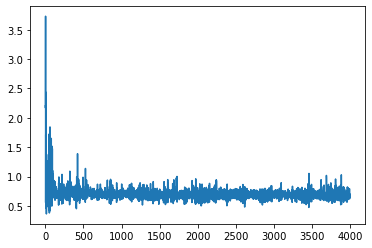

In [36]:
losses = []
for epoch in range(2):
    for data in tqdm(dset_loaders['train']):
        inputs, labels, _ = data
        
        ### If you are using a gpu, then script will move the loaded data to the GPU. 
        ### If you are not using a gpu, ensure that wandb_configs['use_gpu'] is set to False above.
        if wandb_config['use_gpu']:
            inputs = inputs.float().cuda()
            labels = labels.long().cuda()
        else:
            print('WARNING: NOT USING GPU!')
            inputs = inputs.float()
            labels = labels.long()

        
        ### We set the gradients to zero, then calculate the outputs, and the loss function. 
        ### Gradients for this process are automatically calculated by PyTorch.
        
        optimizer_ft.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        loss = criterion(outputs, labels)
        
        
        ### At this point, the program has calculated gradient of loss w.r.t. weights of our NN model.
        loss.backward()
        optimizer_ft.step()
        losses.append(loss)
        clear_output()
        plt.plot(losses)
        plt.show()

### Congratulations!

You just completed your dog vs cats classification! 

# Deliverables for Assignment 2: 

### Like assignment 1, the delivarables are two fold:

Please run this assignment through to the end, and then make two submissions:

- Download this notebook as an HTML file. Click File ---> Download as ---> HTML. Submit this on canvas.
- Add, commit and push these changes to your github repository.